# Ejercicio repaso EDA
## Incialización
Es muy común que la primera celda de un Jupyter Notebook en un EDA incluya algunas configuraciones generales para trabajar de forma cómoda y evitar problemas.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (10, 6)   # tamaño por defecto
sns.set(style="whitegrid")                 # estilo de seaborn

pd.set_option("display.max_columns", None)   # mostrar todas las columnas
pd.set_option("display.max_rows", 100)       # limitar filas mostradas

np.random.seed(42)

## 1. Carga de datos y vistazo general
 ¿qué rangos y escalas presentan las variables? ¿detecta valores extremos aparentes a simple vista?

In [26]:
df_raw = pd.read_csv("./datasets/calidad-del-aire-datos-historicos-diarios.csv", sep=";")
df = df_raw.copy()
print("\nDimensiones iiciales: ", df.shape)
print("\nPrimeras líneas")
df.head()
print("\nInformación")
df.info()
print("\nEstadísticos")
df.describe()



Dimensiones iiciales:  (446014, 13)

Primeras líneas

Información
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446014 entries, 0 to 446013
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Fecha         446014 non-null  object 
 1   CO (mg/m3)    101158 non-null  float64
 2   NO (ug/m3)    415030 non-null  float64
 3   NO2 (ug/m3)   413497 non-null  float64
 4   O3 (ug/m3)    275414 non-null  float64
 5   PM10 (ug/m3)  344579 non-null  float64
 6   PM25 (ug/m3)  53784 non-null   float64
 7   SO2 (ug/m3)   356277 non-null  float64
 8   Provincia     446014 non-null  object 
 9   Estación      446014 non-null  object 
 10  Latitud       445788 non-null  float64
 11  Longitud      445788 non-null  float64
 12  Posición      445788 non-null  object 
dtypes: float64(9), object(4)
memory usage: 44.2+ MB

Estadísticos


,CO (mg/m3),NO (ug/m3),NO2 (ug/m3),O3 (ug/m3),PM10 (ug/m3),PM25 (ug/m3),SO2 (ug/m3),Latitud,Longitud
count,101158.000000,415030.000000,413497.000000,275414.000000,344579.000000,53784.000000,356277.000000,445788.000000,445788.000000
mean,0.854624,13.225808,21.409154,52.619754,22.694662,13.677172,9.092801,42.151547,-5.178965
std,0.785226,21.970729,19.108434,23.221958,17.919319,15.895495,13.790750,0.665501,1.121920
min,0.000000,-441.000000,0.000000,0.000000,0.000000,0.000000,-791.000000,38.938333,-6.781944
25%,0.300000,2.000000,8.000000,37.000000,11.000000,5.000000,2.000000,41.645556,-6.483889
50%,0.700000,5.000000,16.000000,54.000000,18.000000,9.000000,5.000000,42.542778,-4.909167
75%,1.100000,15.000000,29.000000,68.000000,29.000000,15.000000,11.000000,42.688056,-4.538333
max,25.100000,634.000000,249.000000,999.000000,557.000000,223.000000,364.000000,43.603333,-2.466667


### Conclusiones primer vistazo
- Faltan muchos datos en muchas columnas
- Nombres de columnas convendria normalizarlas. Sin acentos y todo minuscula
- Concentracines negativas de algunos contaminantes
- Sobran columnas o bien Latitud / Longitud o Posicion

$$
H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)
$$

Normalizamos nombres de columnas con unicodedata

In [27]:
import unicodedata

# Función para normalizar nombres de columnas
def normalize_columns(df):
    df.columns = (
        df.columns
        .str.strip()  # quitar espacios al inicio/fin
        .str.lower()  # pasar a minúsculas
        .str.replace(" ", "_")  # reemplazar espacios por "_"
        .str.replace(r"[^\w\s]", "", regex=True)  # eliminar caracteres no alfanuméricos
    )
    # quitar acentos
    df.columns = [
        unicodedata.normalize("NFKD", col).encode("ascii", "ignore").decode("utf-8")
        for col in df.columns
    ]
    return df

# Ejemplo de uso
df = normalize_columns(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446014 entries, 0 to 446013
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   fecha      446014 non-null  object 
 1   co_mgm3    101158 non-null  float64
 2   no_ugm3    415030 non-null  float64
 3   no2_ugm3   413497 non-null  float64
 4   o3_ugm3    275414 non-null  float64
 5   pm10_ugm3  344579 non-null  float64
 6   pm25_ugm3  53784 non-null   float64
 7   so2_ugm3   356277 non-null  float64
 8   provincia  446014 non-null  object 
 9   estacion   446014 non-null  object 
 10  latitud    445788 non-null  float64
 11  longitud   445788 non-null  float64
 12  posicion   445788 non-null  object 
dtypes: float64(9), object(4)
memory usage: 44.2+ MB


In [28]:
cols_cat = ['fecha', 'provincia', 'estacion', 'posicion']
for col in cols_cat:
  print(f'Columna {col}: {df[col].nunique()} subniveles')


Columna fecha: 8766 subniveles
Columna provincia: 10 subniveles
Columna estacion: 91 subniveles
Columna posicion: 106 subniveles


In [29]:
# Codificando bits quita NAs. Nosotros no podemos. Nos quedariamos con 1047 filas escalas
# df.dropna(inplace=True)
# Lo que si hacemos es eliminar duplicadosaunque no tiene efecto
df.drop_duplicates(inplace=True)
print("\nDimensiones tras NA: ", df.shape)
df.info()


Dimensiones tras NA:  (446014, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446014 entries, 0 to 446013
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   fecha      446014 non-null  object 
 1   co_mgm3    101158 non-null  float64
 2   no_ugm3    415030 non-null  float64
 3   no2_ugm3   413497 non-null  float64
 4   o3_ugm3    275414 non-null  float64
 5   pm10_ugm3  344579 non-null  float64
 6   pm25_ugm3  53784 non-null   float64
 7   so2_ugm3   356277 non-null  float64
 8   provincia  446014 non-null  object 
 9   estacion   446014 non-null  object 
 10  latitud    445788 non-null  float64
 11  longitud   445788 non-null  float64
 12  posicion   445788 non-null  object 
dtypes: float64(9), object(4)
memory usage: 44.2+ MB


## 2. Ajuste de tipos y normalización de nombres 
- Convierta `Fecha` a formato datetime (incluya `dayfirst=True` si corresponde).
- Convierta `Provincia` y `Estación` a tipo categórico
- Liste categorías únicas de `Provincia` y `Estación` e indique si observa posibles duplicidades por diferencias ortográficas o de formato.

In [30]:
df["fecha"] = pd.to_datetime(df["fecha"], format="%Y-%m-%d", errors="coerce")

# 2) Cuántas/qué filas quedaron inválidas
mask_invalid = df["fecha"].isna()
n_invalid = mask_invalid.sum()
print(f"Filas con fecha inválida: {n_invalid} ({n_invalid/len(df):.2%})")

Filas con fecha inválida: 0 (0.00%)


In [31]:
#Codificando Bits. Forma de comprobar valores en columnas
cols_cat = ['provincia', 'estacion']
for col in cols_cat:
    df[col] = df[col].str.lower()

#Codificando Bits. sns.countplot()
for col in cols_cat:
    print(f"\n--- {col.upper()} ---")
    print(f"{df[col].nunique()} {col}s")
    print(df[col].value_counts(dropna=False))  # incluye también NaN




--- PROVINCIA ---
10 provincias
provincia
león          176821
valladolid     80460
palencia       61857
burgos         57906
salamanca      31204
soria          10482
zamora          8398
segovia         8245
avila           7389
madrid          3252
Name: count, dtype: int64

--- ESTACION ---
91 estacions
estacion
guardo                              8644
leon1                               8630
la robla                            8577
burgos4                             8532
miranda de ebro2                    8521
medina del campo                    8503
miranda de ebro1                    8224
renault3                            8154
renault2                            8095
renault4                            8082
renault1                            7922
burgos1                             7672
c.t.g. - compuerto                  7211
c.t.g. - villalba                   7039
michelin2                           6871
salamanca5                          6778
c.t.compostilla-cortiguer

In [32]:
for col in cols_cat:
    df[col] = df[col].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446014 entries, 0 to 446013
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   fecha      446014 non-null  datetime64[ns]
 1   co_mgm3    101158 non-null  float64       
 2   no_ugm3    415030 non-null  float64       
 3   no2_ugm3   413497 non-null  float64       
 4   o3_ugm3    275414 non-null  float64       
 5   pm10_ugm3  344579 non-null  float64       
 6   pm25_ugm3  53784 non-null   float64       
 7   so2_ugm3   356277 non-null  float64       
 8   provincia  446014 non-null  category      
 9   estacion   446014 non-null  category      
 10  latitud    445788 non-null  float64       
 11  longitud   445788 non-null  float64       
 12  posicion   445788 non-null  object        
dtypes: category(2), datetime64[ns](1), float64(9), object(1)
memory usage: 38.3+ MB


In [33]:
# Eliminamos la columna posición en todas las filas
df.drop(columns=["posicion"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446014 entries, 0 to 446013
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   fecha      446014 non-null  datetime64[ns]
 1   co_mgm3    101158 non-null  float64       
 2   no_ugm3    415030 non-null  float64       
 3   no2_ugm3   413497 non-null  float64       
 4   o3_ugm3    275414 non-null  float64       
 5   pm10_ugm3  344579 non-null  float64       
 6   pm25_ugm3  53784 non-null   float64       
 7   so2_ugm3   356277 non-null  float64       
 8   provincia  446014 non-null  category      
 9   estacion   446014 non-null  category      
 10  latitud    445788 non-null  float64       
 11  longitud   445788 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(9)
memory usage: 34.9 MB


### Conclusión \#2.
No hay errores ortográficos en las provincias ni en las estaciones ni errores de fecha

## 3. Distribución de variables numéricas 
- Genere histogramas para todas las variables numéricas. **Antes vamos a tratar outliers y NAs pues afectan demasiado**

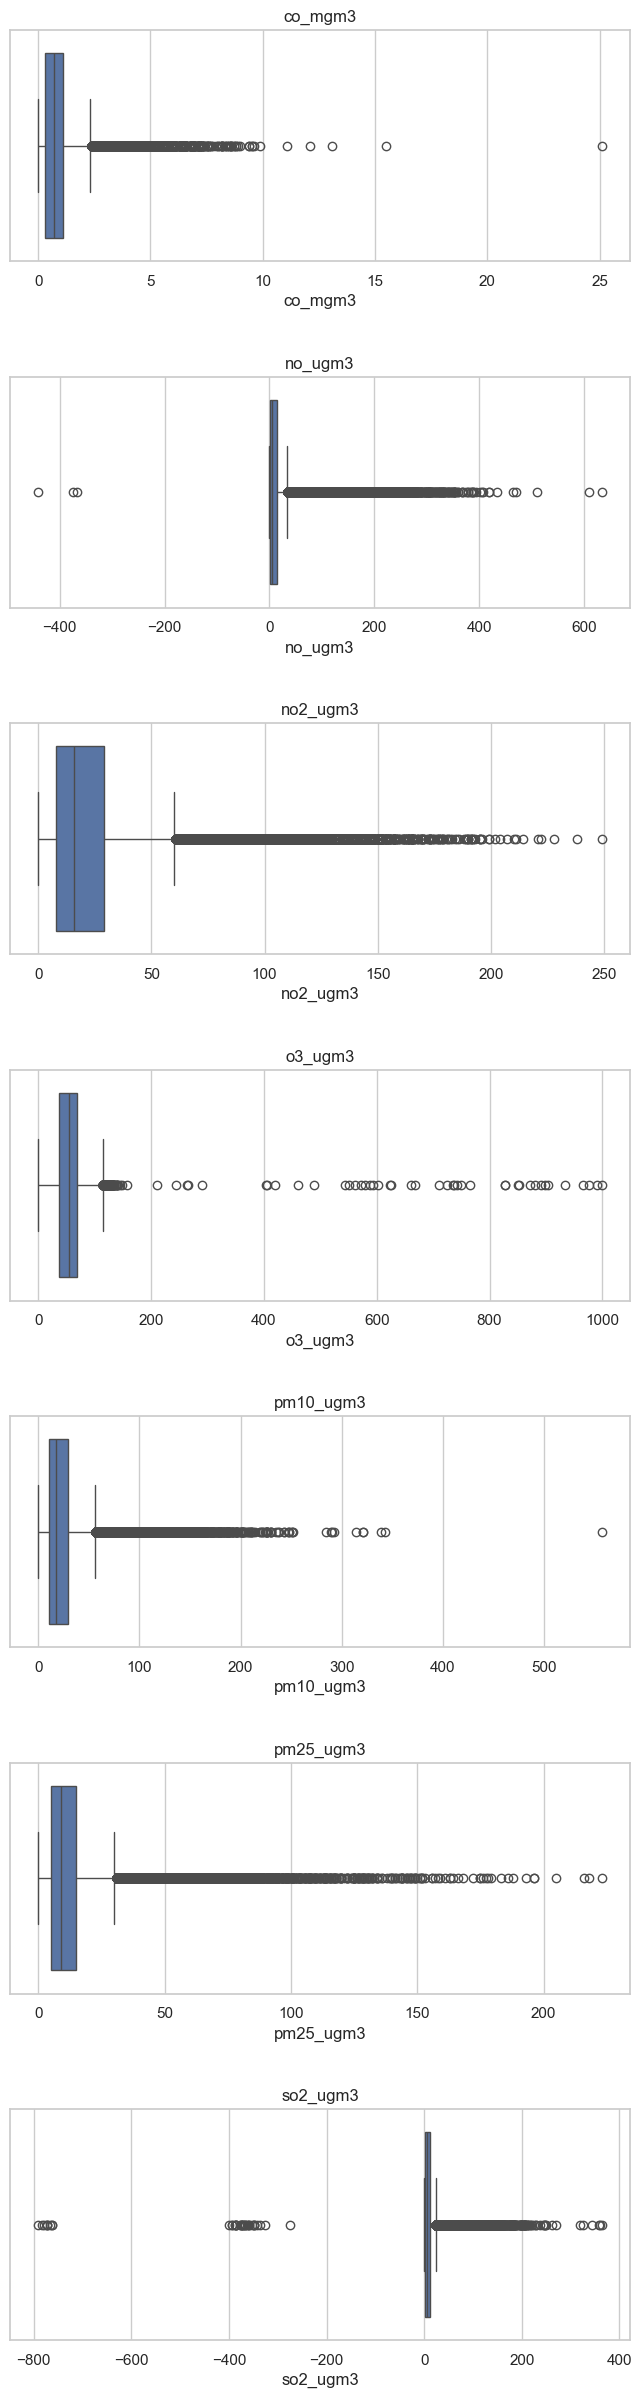

In [34]:
cols_num = ["co_mgm3", "no_ugm3", "no2_ugm3", "o3_ugm3", "pm10_ugm3", "pm25_ugm3", "so2_ugm3"]
fig, ax = plt.subplots(nrows=7, ncols = 1, figsize=(8,30))
fig.subplots_adjust(hspace=0.5)
for i, col in enumerate(cols_num):
    sns.boxplot(x=col, data=df, ax=ax[i])
    ax[i].set_title(col)

## 4. Análisis de valores ausentes (NA)
- Contar NAs. Descartar columnas > 50% NAs
- Imputar medias o medianas

In [35]:
# Contar NAs en valor absoluto y porcentual
na_counts = df.isna().sum().sort_values(ascending=False)
na_percent = (df.isna().mean() * 100).round(2).sort_values(ascending=False)
na_summary = pd.DataFrame({
    'NAs absolutos': na_counts,
    'NAs (%)': na_percent
})
display(na_summary)

,NAs absolutos,NAs (%)
pm25_ugm3,392230,87.94
co_mgm3,344856,77.32
o3_ugm3,170600,38.25
pm10_ugm3,101435,22.74
so2_ugm3,89737,20.12
no2_ugm3,32517,7.29
no_ugm3,30984,6.95
longitud,226,0.05
latitud,226,0.05
fecha,0,0.00


In [36]:
# Seleccionar columnas con menos del 50% de valores NA
cols_to_keep = na_summary[na_summary['NAs (%)'] <= 50].index.tolist()
df = df[cols_to_keep]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 446014 entries, 0 to 446013
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   o3_ugm3    275414 non-null  float64       
 1   pm10_ugm3  344579 non-null  float64       
 2   so2_ugm3   356277 non-null  float64       
 3   no2_ugm3   413497 non-null  float64       
 4   no_ugm3    415030 non-null  float64       
 5   longitud   445788 non-null  float64       
 6   latitud    445788 non-null  float64       
 7   fecha      446014 non-null  datetime64[ns]
 8   estacion   446014 non-null  category      
 9   provincia  446014 non-null  category      
dtypes: category(2), datetime64[ns](1), float64(7)
memory usage: 28.1 MB


## 6.	Detección de valores atípicos (outliers) en variables numéricas

In [37]:
cols_num = ["no_ugm3", "no2_ugm3", "o3_ugm3", "pm10_ugm3", "so2_ugm3"]

# Verificar columnas cion valores negativos
print((df[cols_num] < 0).sum())

# Eliminar filas con valores negativos en esas columnas
# Usando query (muy legible)
df = df.query("no_ugm3 >= 0 and so2_ugm3 >= 0")

# Verificar de nuevo cion valores negativos
print((df[cols_num] < 0).sum())



no_ugm3       3
no2_ugm3      0
o3_ugm3       0
pm10_ugm3     0
so2_ugm3     41
dtype: int64
no_ugm3      0
no2_ugm3     0
o3_ugm3      0
pm10_ugm3    0
so2_ugm3     0
dtype: int64


## 6.1. Winsorizacion

no_ugm3: recortados por winsorización = 6319 (1.87%)  | límites [1, 111]
no2_ugm3: recortados por winsorización = 3388 (1.01%)  | límites [1, 92]
o3_ugm3: recortados por winsorización = 3943 (1.80%)  | límites [6, 100]
pm10_ugm3: recortados por winsorización = 3872 (1.39%)  | límites [2, 89]
so2_ugm3: recortados por winsorización = 4157 (1.23%)  | límites [1, 65]


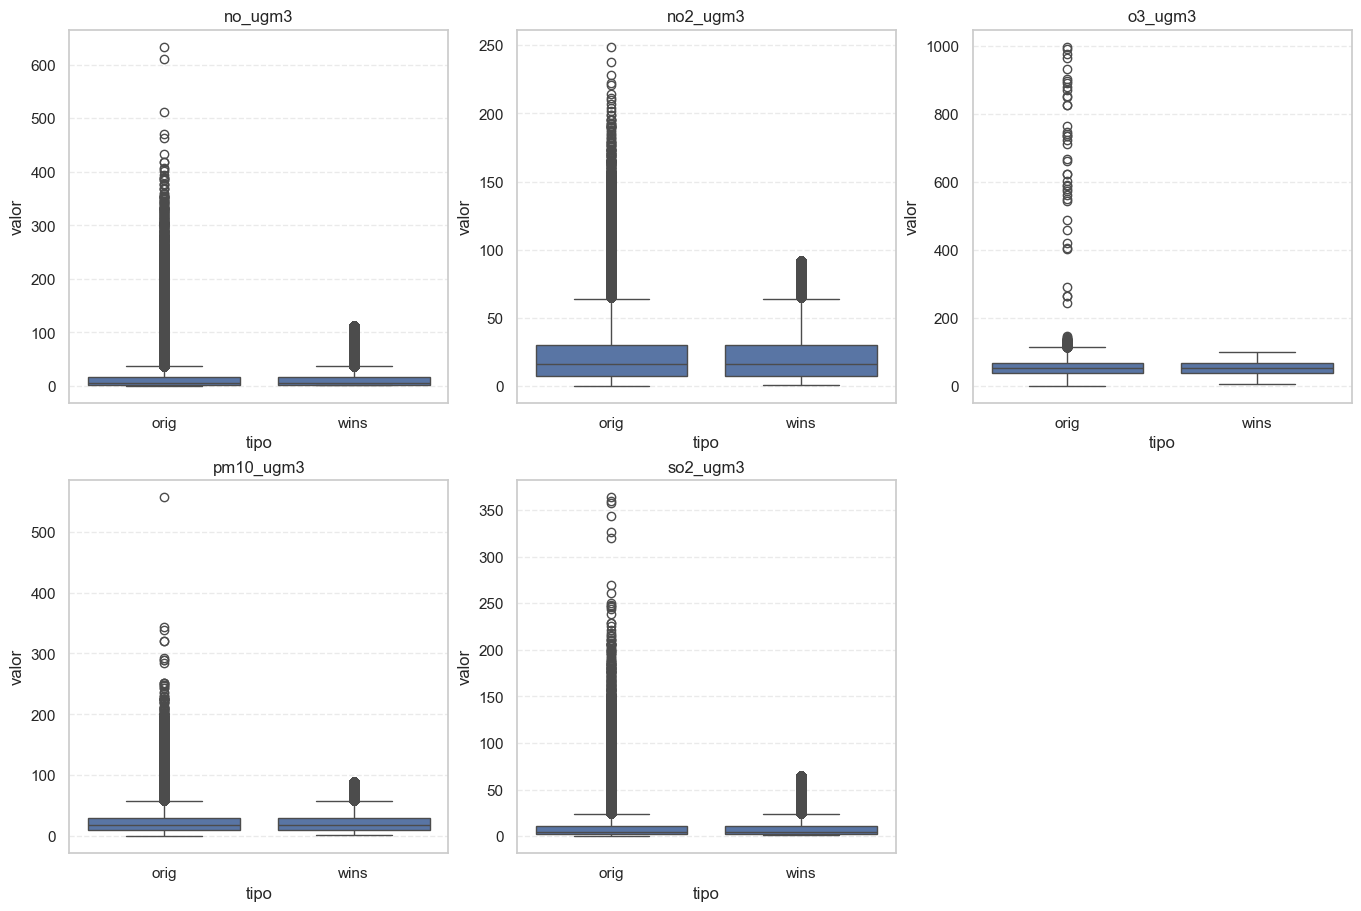

In [48]:

import math
principal = ["no_ugm3", "no2_ugm3", "o3_ugm3", "pm10_ugm3", "so2_ugm3"]

# Parámetro de winsorización: recorta 1% en cada cola (ajústalo si quieres)
alpha = 0.01

# Asegurar numérico y crear columnas winsorizadas con sufijo _w
for col in principal:
    # A numérico (coerce -> NaN si algo no es convertible)
    df[col] = pd.to_numeric(df[col], errors="coerce")

    # Umbrales por percentil
    lo = df[col].quantile(alpha)
    hi = df[col].quantile(1 - alpha)

    # Aplicar winsorización (clip)
    df[col + "_w"] = df[col].clip(lower=lo, upper=hi)

    # Reportar cuántos valores fueron recortados
    n_low = (df[col] < lo).sum()
    n_high = (df[col] > hi).sum()
    n_clip = int(n_low + n_high)
    total = df[col].notna().sum()
    pct = (100 * n_clip / total) if total else 0
    print(f"{col}: recortados por winsorización = {n_clip} ({pct:.2f}%)  | límites [{lo:.3g}, {hi:.3g}]")

# ---- Boxplots: 3 por fila (orig vs wins) ----
n = len(principal)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4.5, n_rows*4.5), constrained_layout=True)

# Por si axes es 1D cuando solo hay una fila
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(principal):
    ax = axes[i]
    # Armamos un DataFrame en formato "largo" para seaborn
    temp = pd.DataFrame({
        "valor": pd.concat([df[col].dropna(), df[col + "_w"].dropna()]),
        "tipo": (["orig"] * df[col].dropna().shape[0]) + (["wins"] * df[col + "_w"].dropna().shape[0])
    })
    sns.boxplot(x="tipo", y="valor", data=temp, ax=ax)
    ax.set_title(col)
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)

# Ocultar ejes sobrantes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()



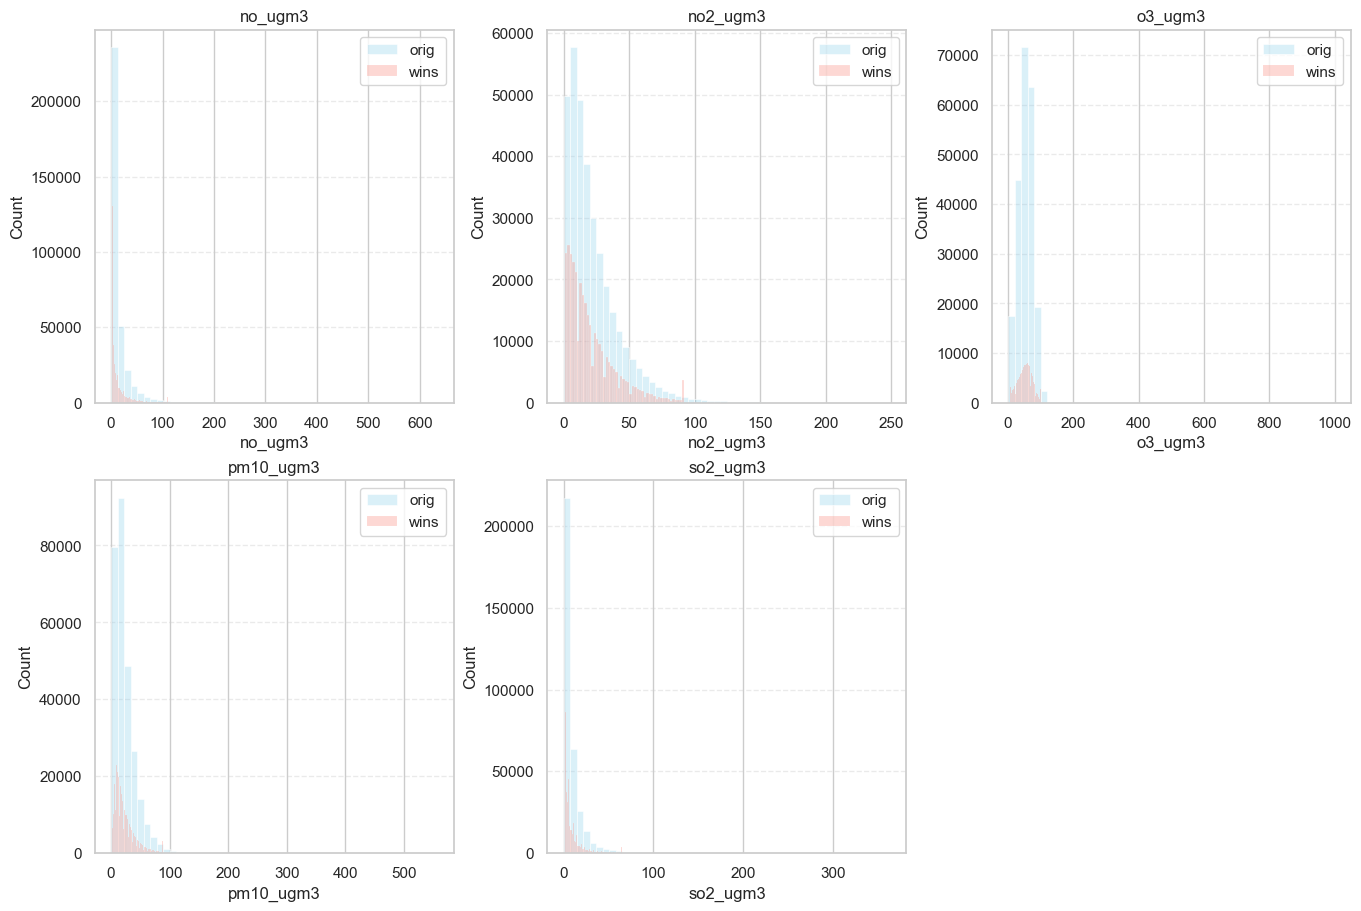

In [43]:
# ---- Boxplots: 3 por fila (orig vs wins) ----
n = len(principal)
n_cols = 3
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4.5, n_rows*4.5), constrained_layout=True)

# Por si axes es 1D cuando solo hay una fila
axes = np.atleast_1d(axes).ravel()

for i, col in enumerate(principal):
    ax = axes[i]
    sns.histplot(df[col].dropna(), ax=ax, color="skyblue", label="orig", kde=False, bins=50, alpha = 0.3)
    sns.histplot(df[col + "_w"].dropna(), ax=ax, color="salmon", label="wins", kde=False, bins=50, alpha=0.3)
    ax.set_title(col)
    ax.grid(True, axis="y", linestyle="--", alpha=0.4)
    ax.legend()

# Ocultar ejes sobrantes
for j in range(i+1, len(axes)):
    axes[j].axis("off")

plt.show()


In [ ]:
principal = ["o3_ugm3", "pm10_ugm3", "so2_ugm3", "no2_ugm3", "no_ugm3"]

df_limpio = df.copy()
for col in principal:
    df_limpio[col] = df_limpio[col + "_w"]

# (Opcional) eliminar las columnas "_w"
df_limpio.drop(columns=[col + "_w" for col in principal], inplace=True)
print(df.info())

KeyError: 'no2ugm3_w'